In [116]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import pickle
import json
from tqdm import tqdm
import os, subprocess
import h5py
import random
import collections
import time

In [117]:
from importlib import reload

In [118]:
import pandas as pd
from scipy.stats import pearsonr

In [119]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [120]:
import rsatoolbox

In [121]:
np.random.seed(7)
torch.manual_seed(7)
random.seed(7)

In [122]:
from domainbed import hparams_registry
from domainbed import algorithms
from domainbed.lib import misc

In [123]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [124]:
import utils
import metrics

In [125]:
# SceneCOCO, ColorObject
# args = utils.load_param("ColorObject")
args = utils.load_param("SceneCOCO")

In [12]:
# open stuff
_path = f'saved_dict_{args.dataset}_Final.pkl'
with open(_path, 'rb') as f:
    print(f"loaded {_path}")
    saved_dict = pickle.load(f)

loaded saved_dict_SceneCOCO_Final.pkl


In [19]:
# read subspaces sets
num_rand_paires = 10
h5_file = h5py.File(os.path.join(args.data_dir, f"test_subspaces_sample{num_rand_paires}.h5py"), "r")
X_subspaces = h5_file.get('images')[()]
h5_file.close()

# dataloader - subspaces
dataset = utils.SimpleDataset_masksize(X_subspaces, np.zeros(X_subspaces.shape[0]), np.zeros(X_subspaces.shape[0]))
data_loader_subspaces = torch.utils.data.DataLoader(dataset=dataset, batch_size=1534,
                                                 num_workers=0, shuffle=False)

In [22]:
# read prob3
h5_file = h5py.File(os.path.join(args.data_dir, "prob3.h5py"), "r")
X_prob3 = h5_file.get('images')[()]
y_prob3_fg = h5_file.get('fg_classes')[()]
y_prob3_bg = h5_file.get('bg_classes')[()]
y_prob3 = np.zeros(y_prob3_fg.shape)
y_prob3[:1000] = y_prob3_fg[:1000]
y_prob3[1000:] = y_prob3_bg[1000:]+10
mask_size_prob3 = h5_file.get('mask_size')[()]
h5_file.close()

# probe set - for RSA and probing acc
dataset = utils.SimpleDataset_masksize(X_prob3, y_prob3, mask_size_prob3)
data_loader_prob3 = torch.utils.data.DataLoader(dataset=dataset, batch_size=1024,
                                                 num_workers=0, shuffle=False)

# h5_file = h5py.File(os.path.join(args.data_dir, "prob1.h5py"), "r")
# X_prob1 = h5_file.get('images')[()]
# y_prob1 = h5_file.get('fg_classes')[()]
# h5_file.close()

# h5_file = h5py.File(os.path.join(args.data_dir, "prob2.h5py"), "r")
# X_prob2 = h5_file.get('images')[()]
# y_prob2 = h5_file.get('bg_classes')[()]
# h5_file.close()

In [23]:
# read ood1
h5_file = h5py.File(os.path.join(args.data_dir, "test_ood1.h5py"), "r")
X_OOD1 = h5_file.get('images')[()]
y_OOD1_fg = h5_file.get('fg_classes')[()]
y_OOD1_bg = h5_file.get('bg_classes')[()]
mask_size_OOD1 = np.zeros(X_OOD1.shape)
h5_file.close()

# dataloader - ood1
dataset = utils.SimpleDataset_masksize(X_OOD1, y_OOD1_fg, mask_size_OOD1)
data_loader_OOD1 = torch.utils.data.DataLoader(dataset=dataset, batch_size=1024,
                                                 num_workers=0, shuffle=False)

In [24]:
# read prob - randomly flip fg/bg
h5_file = h5py.File(os.path.join(args.data_dir, "prob_random_paires.h5py"), "r")
X_prob_rand_paires = h5_file.get('images')[()]
y_prob_rand_paires = np.zeros(len(X_prob_rand_paires))
mask_size_rand_paires = h5_file.get('mask_size')[()]
h5_file.close()

# dataloader - randomly flip fg/bg - for weighted evidence metrics
dataset_rand_paires = utils.SimpleDataset_masksize(X_prob_rand_paires, y_prob_rand_paires, mask_size_rand_paires)
data_loader_rand_paires = torch.utils.data.DataLoader(dataset=dataset_rand_paires, batch_size=1024,
                                                 num_workers=0, shuffle=False)

In [25]:
import metrics
target_rdms = metrics.create_target_rdm(args.data_dir)

In [26]:
dataloaders = (data_loader_prob3, data_loader_rand_paires, data_loader_OOD1, data_loader_subspaces)
ylabels = (y_prob3, y_OOD1_fg, y_OOD1_bg)

In [27]:
utils = reload(utils)
metrics = reload(metrics)

In [ ]:
## all baselines - ColorObject & SceneObject
args.use_two_labels = False
args.use_mask = False
seed_list = [0, 7, 77, 8, 88,
             1, 777, 7777, 888, 8888]
for _algo in ["ERM", "IRM", "VREx", "GroupDRO", "Fish", "MLDG"]:
    for _seed in seed_list:
        args.algorithm = _algo
        args.trial_seed = _seed
        _exp_name=f"{args.bias}_{args.algorithm}_seed{args.trial_seed}"      
        args.exp_name = _exp_name
        saved_dict = utils.prob_model(args, saved_dict, target_rdms, 
                                      dataloaders, ylabels)

9and7_ERM_seed0
==> getting feats...
got feats for layer1
got feats for layer2
got feats for layer4
computing fact subspaces...
==>layer1...
==>layer2...
==>layer4...
time: 254.5671
9and7_ERM_seed7
==> getting feats...
got feats for layer1
got feats for layer2
got feats for layer4
computing fact subspaces...
==>layer1...
==>layer2...
==>layer4...
time: 235.6611
9and7_ERM_seed77
==> getting feats...
got feats for layer1
got feats for layer2
got feats for layer4
computing fact subspaces...
==>layer1...
==>layer2...
==>layer4...
time: 251.3063
9and7_ERM_seed8
==> getting feats...
got feats for layer1
got feats for layer2
got feats for layer4
computing fact subspaces...
==>layer1...
==>layer2...
==>layer4...
time: 255.4934
9and7_ERM_seed88
==> getting feats...
got feats for layer1
got feats for layer2
got feats for layer4
computing fact subspaces...
==>layer1...
==>layer2...
==>layer4...
time: 250.1639
9and7_ERM_seed1
==> getting feats...
got feats for layer1
got feats for layer2
got feats

In [ ]:
## all augmentation - ColorObject & SceneObject
seed_list = [0, 7, 77, 8, 88,
             1, 777, 7777, 888, 8888]
args.algorithm = "ERM_augmentation"
for _seed in seed_list:
    args.use_two_labels = True
    args.use_mask = True
    args.aug_fg = True
    args.aug_bg = True
    
    args.trial_seed = _seed
    
    _exp_name=f"{args.bias}_{args.algorithm}_fgRandom_seed{_seed}"
    args.exp_name = _exp_name
    saved_dict = utils.prob_model(args, saved_dict, target_rdms, dataloaders, ylabels)
    
    _exp_name=f"{args.bias}_{args.algorithm}_bgOnly_seed{_seed}"
    args.exp_name = _exp_name
    saved_dict = utils.prob_model(args, saved_dict, target_rdms, dataloaders, ylabels)
    
    _exp_name=f"{args.bias}_{args.algorithm}_fgRandom_bgOnly_seed{_seed}"
    args.exp_name = _exp_name
    saved_dict = utils.prob_model(args, saved_dict, target_rdms, dataloaders, ylabels)

In [ ]:
## all augmentation - mixed - ColorObject & SceneObject
seed_list = [0, 7, 77, 8, 88,
             1, 777, 7777, 888, 8888]

mix_rate_list = [0.1, 0.2, 0.3, 0.4, 
                 0.6, 0.7, 0.8, 0.9]
args.algorithm = "ERM_augmentation"
for _seed in seed_list:
    for _mix_rate in mix_rate_list:
        args.use_two_labels = True
        args.use_mask = True
        args.aug_fg = True
        args.aug_bg = True

        args.trial_seed = _seed

        _exp_name = f"{args.bias}_ERM_augmentation_fgRandom_bgOnly_MixRate{_mix_rate}_seed{args.trial_seed}"
        args.exp_name = _exp_name
        saved_dict = utils.prob_model(args, saved_dict, target_rdms, dataloaders, ylabels)

In [ ]:
# ## probing 
# args.algorithm = "ERM_probing_old"
# seed_list = [0, 7, 77, 8, 88,
#              1, 777, 7777, 888, 8888]
# for _sup_ratio in [1.0]:
#     for _seed in seed_list:
#         args.use_two_labels = True
#         args.use_mask = True
#         _exp_name=f"9and7_ERM_probing_ProbingLossWeight1_layer3_ratio{_sup_ratio}_seed{_seed}"
#         prob_model()
        
# ## probing 2heads
# args.algorithm = "ERM_probing_2heads"
# for _seed in seed_list:
#     args.use_two_labels = True
#     args.use_mask = True
#     _exp_name = f"9and7_ERM_probing_2heads_ProbingLossWeight1_layer3_seed{_seed}"
#     prob_model()

# ## probing+orth
# args.algorithm = "ERM_probing_old"
# for _seed in seed_list:
#     args.use_two_labels = True
#     args.use_mask = True
#     _exp_name=f"9and7_ERM_probing_ProbingW1_OrthW1_layer3_seed{_seed}"
#     prob_model()
    
# ## probing - data efficiency
# args.algorithm = "ERM_probing_old"
# for _sup_ratio in [0.05, 0.1, 0.25, 0.5, 0.75]:
#     for _seed in [0, 7, 77]:
#         args.use_two_labels = True
#         args.use_mask = True
#         _exp_name=f"9and7_ERM_probing_ProbingLossWeight1_layer3_ratio{_sup_ratio}_seed{_seed}"
#         prob_model()
        
# ## augmentation
# args.algorithm = "ERM_augmentation"
# for _seed in [0, 7, 77, 8, 88]:
#     args.use_two_labels = True
#     args.use_mask = True
#     args.aug_fg = True
#     args.aug_bg = True
#     _exp_name=f"9and7_{args.algorithm}_seed{_seed}"
#     prob_model()

# ## RSA loss
# args.algorithm = "ERM_RSA"
# for _seed in [0, 7, 77, 8, 88]:
#     args.use_two_labels = True
#     args.use_mask = True
#     _exp_name=f"9and7_ERM_RSA_RSAW1_layer3_seed{_seed}"
#     prob_model()
    
# ## augmentation - fgOnly, fgRandom_bgOnly
# args.algorithm = "ERM_augmentation"
# for _seed in [0, 7, 77, 8, 88,
#              1, 777, 7777, 888, 8888]:
#     args.use_two_labels = True
#     args.use_mask = True
#     args.aug_fg = True
#     args.aug_bg = True
#     _exp_name=f"9and7_ERM_augmentation_fgOnly_seed{_seed}"
#     prob_model()
#     args.use_two_labels = True
#     args.use_mask = True
#     _exp_name=f"9and7_ERM_augmentation_fgRandom_bgOnly_seed{_seed}"
#     prob_model()

In [32]:
# save stuff
with open(f'saved_dict_{args.dataset}_Final.pkl', 'wb') as f:
    pickle.dump(saved_dict, f)

# regression analysis

In [78]:
# open stuff
with open(f'saved_dict_{args.dataset}.pkl', 'rb') as f:
    saved_dict = pickle.load(f)

In [79]:
column_names = ['exp_name', "model_algo", "seed", "test_id", 
                "test_ood1", "test_ood2", "test_ood2ext"]

# add rdm corr
# for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
for layer_name in ['layer1', 'layer2', 'layer4', 'output']:
    if layer_name != 'output':
        column_names.append(f"rsa_obj_scene_{layer_name}")
        column_names.append(f"rsa_cat_sep_{layer_name}")
        column_names.append(f"rsa_co_occure_{layer_name}")
        column_names.append(f"prob3_acc_{layer_name}")
        # column_names.append(f"probOOD1_trad_fg_{layer_name}")
        # column_names.append(f"probOOD1_trad_bg_{layer_name}")
        # column_names.append(f"probOOD1_nSqaure_acc_{layer_name}")
        column_names.append(f'rel_change-rand_pair-l1-sub_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l1-div_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l2-sub_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l2-div_{layer_name}')
        column_names.append(f'fact_subspaces_fg_samples10_{layer_name}')
        column_names.append(f'fact_subspaces_bg_samples10_{layer_name}')
        column_names.append(f'inv_subspaces_fg_samples10_{layer_name}')
        column_names.append(f'inv_subspaces_bg_samples10_{layer_name}')
    else:
        column_names.append(f'rel_change-rand_pair-l1-sub_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l1-div_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l2-sub_{layer_name}')
        column_names.append(f'rel_change-rand_pair-l2-div_{layer_name}')
        column_names.append(f'rel_change-rand_pair-kl-sub_{layer_name}')
        column_names.append(f'rel_change-rand_pair-kl-div_{layer_name}')
column_names.append('fact_subspaces_fg_samples100_layer4')
column_names.append('fact_subspaces_bg_samples100_layer4')
column_names.append('inv_subspaces_fg_samples100_layer4')
column_names.append('inv_subspaces_bg_samples100_layer4')
# column_names.append('rel_act_scale')
# column_names.append('rel_act_scale_v2')

all_data = []
# seed_list = [0, 7, 77, 8, 88,
#              1, 777, 7777, 888, 8888]
# for _algo in ["ERM", "IRM", "VREx", "GroupDRO", "Fish", "MLDG"]:
#     for _seed in seed_list:
#         _exp_name = _exp_name=f"{args.bias}_{_algo}_seed{_seed}"

incomplete_exps = []
for _exp_name in saved_dict.keys():
    model_dict = saved_dict[_exp_name]
    if "fact_subspaces_fg_layer3" not in model_dict:
        incomplete_exps.append(_exp_name)
        continue
    _test_id_acc = (model_dict['test_id_0_acc'] + model_dict['test_id_1_acc']) / 2
    _test_ood2_acc = (model_dict['test_ood2_level1_acc'] + model_dict['test_ood2_level2_acc'] +\
                     model_dict['test_ood2_level3_acc'] + model_dict['test_ood2_level4_acc'] + \
                     model_dict['test_ood2_level5_acc']) / 5
    new_row = [_exp_name, model_dict['algo'], model_dict['seed'], 
               _test_id_acc, model_dict['test_ood1_0.0_acc'], 
               _test_ood2_acc, model_dict['ood2ext_acc']]    

    # rdm corr
    # for layer_name in ['layer1', 'layer2', 'layer3', 'layer4']:
    for layer_name in ['layer1', 'layer2', 'layer4', 'output']:
        if layer_name != 'output':
            new_row.append(model_dict[f"prob3_rsa_obj_scene_{layer_name}"])
            new_row.append(model_dict[f"prob3_rsa_cat_sep_{layer_name}"])
            new_row.append(model_dict[f"prob3_rsa_co_occure_{layer_name}"])
            new_row.append(model_dict[f"prob3_acc_{layer_name}"])
            # new_row.append(model_dict[f"probOOD1_trad_fg_{layer_name}"])
            # new_row.append(model_dict[f"probOOD1_trad_bg_{layer_name}"])
            # new_row.append(model_dict[f"probOOD1_nSqaure_acc_{layer_name}"])
            new_row.append(model_dict[f'rel_change-rand_pair-l1-sub_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l1-div_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l2-sub_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l2-div_{layer_name}'])
            new_row.append(model_dict[f'fact_subspaces_fg_samples10_{layer_name}'])
            new_row.append(model_dict[f'fact_subspaces_bg_samples10_{layer_name}'])
            new_row.append(model_dict[f'inv_subspaces_fg_samples10_{layer_name}'])
            new_row.append(model_dict[f'inv_subspaces_bg_samples10_{layer_name}'])
        else:
            new_row.append(model_dict[f'rel_change-rand_pair-l1-sub_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l1-div_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l2-sub_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-l2-div_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-kl-sub_{layer_name}'])
            new_row.append(model_dict[f'rel_change-rand_pair-kl-div_{layer_name}'])
    new_row.append(model_dict['fact_subspaces_fg_samples100_layer4'])
    new_row.append(model_dict['fact_subspaces_bg_samples100_layer4'])
    new_row.append(model_dict['inv_subspaces_fg_samples100_layer4'])
    new_row.append(model_dict['inv_subspaces_bg_samples100_layer4'])
    
    all_data.append(new_row)

In [81]:
df = pd.DataFrame(all_data, columns = column_names)
# model_algo to onehot
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
jobs_encoder = LabelBinarizer()
jobs_encoder.fit(df['model_algo'])
num_algo = len(pd.unique(df['model_algo']))
transformed = jobs_encoder.transform(df['model_algo'])
onehot_df = pd.DataFrame(transformed, columns=[f'alg_{i}' for i in range(num_algo)])
df = pd.concat([df, onehot_df], axis=1).drop(['model_algo'], axis=1)
df.head()

,exp_name,seed,test_id,test_ood1,test_ood2,test_ood2ext,rsa_obj_scene_layer1,rsa_cat_sep_layer1,rsa_co_occure_layer1,prob3_acc_layer1,...,fact_subspaces_bg_samples100_layer4,inv_subspaces_fg_samples100_layer4,inv_subspaces_bg_samples100_layer4,alg_0,alg_1,alg_2,alg_3,alg_4,alg_5,alg_6
0,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.6995,0.275,0.752800,0.727,0.191007,0.063345,0.014530,0.315507,...,0.055714,0.541346,0.360020,0,1,0,0,0,0,0
1,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7415,0.353,0.745067,0.735,0.235267,0.076299,0.016194,0.344993,...,0.068042,0.442040,0.454847,0,1,0,0,0,0,0
2,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7490,0.381,0.732000,0.729,0.251697,0.075342,0.013056,0.303996,...,0.077125,0.386347,0.516998,0,1,0,0,0,0,0
3,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7620,0.417,0.722267,0.734,0.200766,0.066626,0.014824,0.309995,...,0.095791,0.345925,0.556452,0,1,0,0,0,0,0
4,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7455,0.461,0.670800,0.694,0.307689,0.095379,0.018034,0.334499,...,0.110140,0.295623,0.617432,0,1,0,0,0,0,0


In [82]:
# subset 
if args.dataset == 'SceneCOCO':
    df_sub = df
if args.dataset == 'ColorObject':
    df_sub = df[df['test_ood1']>0.15]

In [83]:
# add percentile
from scipy import stats
def add_percentile(name):
    tmp = df_sub[name].tolist()
    percentiles = [stats.percentileofscore(tmp, a, 'rank') for a in tmp]
    df_sub[name+'_percentile'] = percentiles
add_percentile("test_ood1")
add_percentile("test_ood2")

In [84]:
from scipy.stats import hmean
def add_two_column(name1, name2, new_name, normalize=True, HMEAN=False):
    if normalize:
        range1 = df_sub[name1].values.max() - df_sub[name1].values.min()
        range2 = df_sub[name2].values.max() - df_sub[name2].values.min()
        norm = range2 / range1
        print("normalization factor: %.4f" % (norm))
    else:
        norm = 1
    new_list = df_sub[name1].values * norm + df_sub[name2].values
    
    if HMEAN:
        new_list = hmean(df_sub[[name1, name2]].to_numpy(), axis=1)
    df_sub[new_name] = new_list.tolist()

In [85]:
# add_two_column('test_ood1', 'test_ood2_severe', 'ood1_mix_ood2severe_norm', normalize=True)
# add_two_column('test_ood1', 'test_ood2_severe', 'ood1_mix_ood2severe_ori', normalize=False)
add_two_column('test_ood1', 'test_ood2', 'ood1_mix_ood2_norm', normalize=True)
add_two_column('test_ood1', 'test_ood2', 'ood1_mix_ood2_ori', normalize=False)
add_two_column('test_ood1', 'test_ood2', 'ood1_mix_ood2_hmean', normalize=False, HMEAN=True)
add_two_column('test_ood1', 'test_ood2ext', 'ood1_mix_ood2ext_norm', normalize=True)
add_two_column('test_ood1', 'test_ood2ext', 'ood1_mix_ood2ext_ori', normalize=False)

add_two_column('test_ood1_percentile', 'test_ood2_percentile', 
               'ood1_mix_ood2_percentile', normalize=False)

df_sub.head()

normalization factor: 0.7902
normalization factor: 1.0627


,exp_name,seed,test_id,test_ood1,test_ood2,test_ood2ext,rsa_obj_scene_layer1,rsa_cat_sep_layer1,rsa_co_occure_layer1,prob3_acc_layer1,...,alg_5,alg_6,test_ood1_percentile,test_ood2_percentile,ood1_mix_ood2_norm,ood1_mix_ood2_ori,ood1_mix_ood2_hmean,ood1_mix_ood2ext_norm,ood1_mix_ood2ext_ori,ood1_mix_ood2_percentile
0,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.6995,0.275,0.752800,0.727,0.191007,0.063345,0.014530,0.315507,...,0,0,8.823529,90.000000,0.970094,1.027800,0.402841,1.019251,1.002,98.823529
1,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7415,0.353,0.745067,0.735,0.235267,0.076299,0.016194,0.344993,...,0,0,35.294118,84.705882,1.023993,1.098067,0.479039,1.110144,1.088,120.000000
2,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7490,0.381,0.732000,0.729,0.251697,0.075342,0.013056,0.303996,...,0,0,55.882353,76.470588,1.033051,1.113000,0.501154,1.133900,1.110,132.352941
3,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7620,0.417,0.722267,0.734,0.200766,0.066626,0.014824,0.309995,...,0,0,63.823529,65.294118,1.051763,1.139267,0.528735,1.177159,1.151,129.117647
4,9and7_ERM_augmentation_fgRandom_bgOnly_MixRate...,None,0.7455,0.461,0.670800,0.694,0.307689,0.095379,0.018034,0.334499,...,0,0,74.705882,25.294118,1.035064,1.131800,0.546455,1.183919,1.155,100.000000


In [86]:
len(df_sub)

170

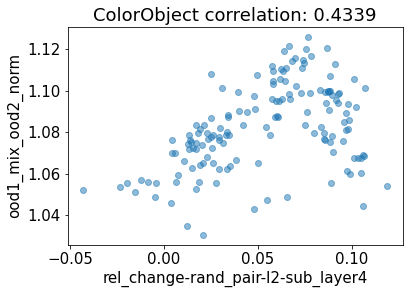

In [29]:
# scatter plot + correlation r
# 'rsa_obj_scene_layer4', 'prob3_acc_layer4', 'rel_change-rand_pair-l2-sub_layer4'
# 'fact_subspaces_fg_layer3', 'fact_subspaces_bg_layer3', 'inv_subspaces_fg_layer3', 'inv_subspaces_bg_layer3'
# 'fact_subspaces_fg_samples100_layer4'
name0 = 'rel_change-rand_pair-l2-sub_layer4' 

# ood1_mix_ood2_ori, ood1_mix_ood2_norm, test_ood1, test_ood2, 
# ood1_mix_ood2_percentile, test_ood1_percentile, test_ood2_percentile
name1 = 'ood1_mix_ood2_norm'

x_data, y_data = df_sub[name0].to_numpy(), df_sub[name1].to_numpy()
plt.scatter(x_data, y_data, alpha=0.5)
plt.xlabel(name0)
plt.ylabel(name1)


plt.title(f"{args.dataset} correlation: %.4f" % (pearsonr(x_data, y_data)[0]))
plt.show()

In [123]:
# func for computing r2 with cv
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

def p_value(betas):
    # calculate p-value for two-sided difference from 0 test with a bootstrapped distribution of statistics, betas
    abs_mean_beta = np.abs(np.mean(betas))
    centered_betas = betas - np.mean(betas)
    outside_prop = np.mean(centered_betas < -abs_mean_beta) + np.mean(centered_betas > abs_mean_beta)
    return outside_prop

def calc_reg_r2(predictor_classes, predictand_class): # with bootstrap
    X = df_sub[predictor_classes].to_numpy()
    y = df_sub[predictand_class].to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)
    
    n_bootstrap = 10000
    bootstrap_coefs = np.zeros((n_bootstrap, X.shape[1]))
    bootstrap_scores = np.zeros(n_bootstrap)
    # Perform bootstrap resampling and fit linear regression model
    for i in tqdm(range(n_bootstrap)):
        # Generate bootstrap sample indices
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
        # Fit linear regression model
        model = LinearRegression()
        model.fit(X_train, y_train)
        # score = model.score(X_test, y_test)
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        bootstrap_scores[i] = r2
        bootstrap_coefs[i] = model.coef_
    
    # compute p-values
    p_values = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        betas = bootstrap_coefs[:, i]
        p_values[i] = p_value(betas)
    results = [bootstrap_scores, bootstrap_coefs, p_values]
    return results


In [131]:
# baselines
predictand_classes = ['ood1_mix_ood2_percentile'] 
# 'ood1_mix_ood2_ori', 'ood1_mix_ood2_hmean', 'ood1_mix_ood2_percentile'
# 'test_ood1', 'test_ood2'

## using id_acc
predictor_classes = ['test_id']
r_sq = calc_reg_r2(predictor_classes, predictand_classes)
print(f"test_id: %.3f±%.3f" % (r_sq[0].mean(), r_sq[0].std()))

## using id_acc + algo
predictor_classes = ['test_id'] + [f'alg_{i}' for i in range(num_algo)]
r_sq = calc_reg_r2(predictor_classes, predictand_classes)
print(f"algo added: %.3f±%.3f" % (r_sq[0].mean(), r_sq[0].std()))

100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1230.91it/s]


test_id: 0.024±0.155


100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1139.19it/s]

algo added: 0.019±0.254


In [133]:
# all fact metrics
layer_name_list = ['layer1', 'layer2', 'layer4']
all_fact_metrics = [f'rsa_cat_sep_{layer_name}' for layer_name in layer_name_list] + \
                [f'prob3_acc_{layer_name}' for layer_name in layer_name_list] + \
                [f'fact_subspaces_fg_samples10_{layer_name}' for layer_name in layer_name_list]             


predictor_classes = all_fact_metrics + ['test_id'] + \
                    [f'alg_{i}' for i in range(num_algo)]

r_sq_fact = calc_reg_r2(predictor_classes, predictand_classes)
print(f"all fact added:\t %.3f±%.3f" % (r_sq_fact[0].mean(), r_sq_fact[0].std()))

# all weighted evidence metrics 
layer_name_list = ['layer1', 'layer2', 'layer4']
all_wt_evid_metrics =   [f'rel_change-rand_pair-l2-sub_{layer_name}' for layer_name in layer_name_list] + \
                        ['rel_change-rand_pair-kl-sub_output']

predictor_classes = all_wt_evid_metrics + ['test_id'] + \
                    [f'alg_{i}' for i in range(num_algo)]

r_sq_wt_evid = calc_reg_r2(predictor_classes, predictand_classes)
print(f"all wt_evid added:\t %.3f±%.3f" % (r_sq_wt_evid[0].mean(), r_sq_wt_evid[0].std()))

# all metrics
all_metrics = all_fact_metrics + all_wt_evid_metrics

predictor_classes = all_metrics + ['test_id'] + \
                    [f'alg_{i}' for i in range(num_algo)]

r_sq = calc_reg_r2(predictor_classes, predictand_classes)
print(f"all metrics added:\t %.3f±%.3f" % (r_sq[0].mean(), r_sq[0].std()))

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1022.16it/s]


all fact added:	 0.038±0.302


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1093.98it/s]


all wt_evid added:	 -0.040±0.289


100%|████████████████████████████████████| 10000/10000 [00:10<00:00, 975.74it/s]

all metrics added:	 -0.031±0.332


In [136]:
from scipy import stats
print(r_sq_wt_evid[0].mean(), r_sq[0].mean())
stats.ttest_ind(r_sq_wt_evid[0], r_sq[0])

-0.039554230068161965 -0.031154003632645897


Ttest_indResult(statistic=-1.9095749073675718, pvalue=0.05620226195675658)

In [64]:
# print weight & p value
for metric_index, metric_name in enumerate(all_metrics + ['test_id']):
    print(f"{metric_name}: %.3f±%.3f (%.3f)" % 
          (r_sq[1][:,metric_index].mean(), r_sq[1][:,metric_index].std(), r_sq[2][metric_index]))

rsa_cat_sep_layer1: -0.059±0.043 (0.163)
rsa_cat_sep_layer2: -0.071±0.029 (0.018)
rsa_cat_sep_layer4: 0.191±0.064 (0.004)
prob3_acc_layer1: 0.019±0.028 (0.485)
prob3_acc_layer2: 0.181±0.036 (0.000)
prob3_acc_layer4: 0.329±0.050 (0.000)
inv_subspaces_fg_samples10_layer1: 0.648±0.115 (0.000)
inv_subspaces_fg_samples10_layer2: -0.085±0.136 (0.523)
inv_subspaces_fg_samples10_layer4: 0.121±0.096 (0.206)
rel_change-rand_pair-l2-sub_layer1: 0.056±0.008 (0.000)
rel_change-rand_pair-l2-sub_layer2: -0.017±0.007 (0.014)
rel_change-rand_pair-l2-sub_layer4: 0.879±0.257 (0.001)
rel_change-rand_pair-kl-sub_output: 0.108±0.056 (0.056)
test_id: 0.811±0.056 (0.000)


## vis fact + wt vs. OOD

In [26]:
# plot fact + wt evid with color as OOD perforamnces

#  read stuff
_path = f'saved_dict_{args.dataset}_Final.pkl'
with open(_path, 'rb') as f:
    saved_dict = pickle.load(f)
    print(f"loaded {_path}")

loaded saved_dict_ColorObject_Final.pkl


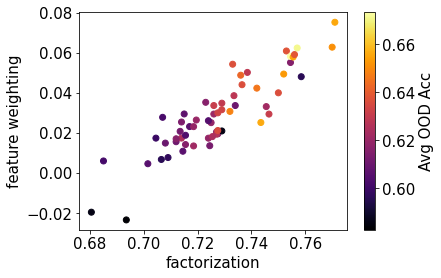

In [27]:
all_fact = []
all_wt_evid = []
all_ood_added = []
for _key, _value in saved_dict.items():
    if 'fgRandom_seed' in _key or "bgOnly_seed" in _key or "MixRate" in _key:
        continue
    all_wt_evid.append(_value['rel_change-rand_pair-l2-sub_layer4'])
    _tmp = (_value['probOOD1_trad_fg_layer4'] + _value['probOOD1_trad_bg_layer4'])/2
    # _tmp = _value['prob3_acc_layer4']
    all_fact.append(_tmp)
    _tmp = (_value['test_ood1_0.0_acc'] + _value['test_ood2_level5_acc'])/2
    all_ood_added.append(_tmp)
    
# Create scatter plot
plt.scatter(all_fact, all_wt_evid, c=all_ood_added, cmap='inferno')
plt.colorbar(label="Avg OOD Acc")

# Set axis labels and title
plt.xlabel('factorization')
plt.ylabel('feature weighting')
plt.show()

# plt.title('Scatter Plot with Color Varying Based on Values')

## plot RDM

In [ ]:
# read prob3
h5_file = h5py.File(os.path.join(args.data_dir, "prob3.h5py"), "r")
X_prob3 = h5_file.get('images')[()]
y_prob3_fg = h5_file.get('fg_classes')[()]
y_prob3_bg = h5_file.get('bg_classes')[()]
y_prob3 = np.zeros(y_prob3_fg.shape)
y_prob3[:1000] = y_prob3_fg[:1000]
y_prob3[1000:] = y_prob3_bg[1000:]+10
mask_size_prob3 = h5_file.get('mask_size')[()]
h5_file.close()

ref_matrix, ref_matrix_cat_specific, ref_matrix_co_occur = metrics.create_target_rdm(args.data_dir)

In [ ]:
# plot reference RDM
for ref_id, ref in enumerate([ref_matrix, ref_matrix_cat_specific, ref_matrix_co_occur]):
    plt.figure(figsize=(7.5,6))

    import matplotlib
    matplotlib.rcParams.update({'font.size': 15})
    plt.imshow(ref, cmap='coolwarm')
    plt.colorbar()
    plt.title("Reference RDM")
    plt.savefig(f"./fig/RDM_target_{ref_id}.png", format="png", dpi=500, bbox_inches = "tight")
    plt.show()

In [ ]:
## get model RDM
# get probe set
dataset = utils.SimpleDataset_masksize(X_prob3, y_prob3, mask_size_prob3)
data_loader_prob3 = torch.utils.data.DataLoader(dataset=dataset, batch_size=256,
                                                 num_workers=0, shuffle=False)

# get model
args.algorithm = "ERM_augmentation"
_seed=0
_mix_rate=0.3
args.use_two_labels = True
args.use_mask = True
args.aug_fg = True
args.aug_bg = True
args.trial_seed = _seed
_exp_name = f"{args.bias}_ERM_augmentation_fgRandom_bgOnly_MixRate{_mix_rate}_seed{args.trial_seed}"
args.exp_name = _exp_name

eval_names = []
_, model = utils.init_data_model(args, eval_names)

# get model FEATS
FEATS = utils.get_feats(args, model, data_loader_prob3, ['layer3'], apply_pca=True)

In [ ]:
# get model RDM
X = FEATS['layer4'] 
num_samples = len(X)
data = rsatoolbox.data.Dataset(X.reshape(num_samples,-1))
rdms = rsatoolbox.rdm.calc_rdm(data)
rdm_matrices = rdms.get_matrices().squeeze()

plt.hist(rdm_matrices.reshape(-1))
plt.show()

In [ ]:
# clip + norm for better vis
upper_bound = 0.5
rdm_matrices[rdm_matrices>upper_bound] = upper_bound
rdm_matrices = rdm_matrices / rdm_matrices.max()

In [ ]:
# plot reference RDM
plt.figure(figsize=(7.5,6))

import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.imshow(rdm_matrices, cmap='coolwarm')
plt.title("Model RDM")
plt.colorbar()
plt.savefig(f"./fig/RDM_model.png", format="png", dpi=500, bbox_inches = "tight")
plt.show()

In [ ]:
pearsonr(ref_matrix.reshape(-1), rdm_matrices.reshape(-1))

## mixing weight

In [ ]:
#  read stuff
_path = f'saved_dict_{args.dataset}_Final.pkl'
with open(_path, 'rb') as f:
    saved_dict = pickle.load(f)
    print(f"loaded {_path}")

In [ ]:
from scipy.stats import ttest_ind
from bstrap import bootstrap, boostrapping_CI
from scipy.stats import hmean

def calc_across_seeds(name, seed_list, metrics_names_list, HMEAN=False, print_results=True):
    results = np.zeros((len(metrics_names_list), len(seed_list)))
    for seed_index, _seed in enumerate(seed_list):
        _exp_name=f"{name}_seed{_seed}"
        for metric_index, metric_name in enumerate(metrics_names_list):
            if type(metric_name) == list:
                tmp_list = []
                for sub_metric_name in metric_name:
                    tmp_list.append(saved_dict[_exp_name][sub_metric_name])
                if HMEAN:
                    results[metric_index][seed_index] = hmean(tmp_list)
                else:
                    results[metric_index][seed_index] = np.mean(tmp_list)
            elif type(metric_name) == str:    
                results[metric_index][seed_index] = saved_dict[_exp_name][metric_name]
            else: 
                assert False

    if print_results:
        print("_".join(_exp_name.split("_")[1:-1]))
        for metric_index, metric_name in enumerate(metrics_names_list):
            print(f"{metric_name}: %.2f±%.2f" % (results[metric_index].mean()*100, results[metric_index].std()*100))
    return results

In [ ]:
# augmentation - mixed rate - ColorObject & SceneObject
HMEAN = False
seed_list = [0, 7, 77, 8, 88,
            1, 777, 7777, 888, 8888]
metrics_names_list = ['test_ood1_0.0_acc', 
                      ['test_ood2_level1_acc', 'test_ood2_level2_acc', 'test_ood2_level3_acc', 
                       'test_ood2_level4_acc', 'test_ood2_level5_acc']] 

args.algorithm = "ERM_augmentation"
mix_rate_list = [0.1, 0.2, 0.3, 0.4, 
                 0.6, 0.7, 0.8, 0.9]

all_results_mixing_weight = []
for _mix_rate in mix_rate_list:
    _exp_name=f"{args.bias}_{args.algorithm}_fgRandom_bgOnly_MixRate{_mix_rate}"
    result = calc_across_seeds(_exp_name, seed_list, metrics_names_list, HMEAN)
    all_results_mixing_weight.append(result)

In [ ]:
# all augmentations - ColorObject & SceneObject
HMEAN = False
seed_list = [0, 7, 77, 8, 88,
            1, 777, 7777, 888, 8888]
metrics_names_list = ['test_ood1_0.0_acc', 
                      ['test_ood2_level1_acc', 'test_ood2_level2_acc', 'test_ood2_level3_acc', 
                       'test_ood2_level4_acc', 'test_ood2_level5_acc']] 

all_results_add = []
args.algorithm = "ERM_augmentation"
_exp_name=f"{args.bias}_{args.algorithm}_fgRandom"
result = calc_across_seeds(_exp_name, seed_list, metrics_names_list, HMEAN)
all_results_add.append(result)

_exp_name=f"{args.bias}_{args.algorithm}_bgOnly"
result = calc_across_seeds(_exp_name, seed_list, metrics_names_list, HMEAN)
all_results_add.append(result)

_exp_name=f"{args.bias}_{args.algorithm}_fgRandom_bgOnly"
result = calc_across_seeds(_exp_name, seed_list, metrics_names_list, HMEAN)
all_results_add.append(result)

In [ ]:
all_results = all_results_add[1:2] + all_results_mixing_weight[:4] + \
                all_results_add[2:] + all_results_mixing_weight[4:] + \
                all_results_add[:1]
all_results = np.array(all_results)

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
plt.figure(figsize=(7,5))

ood1_mean = all_results[:,0].mean(1) * 100
ood1_std = all_results[:,0].std(1) * 100
ood2_mean = all_results[:,1].mean(1) * 100
ood2_std = all_results[:,1].std(1) * 100
avg_ood_mean = (ood1_mean + ood2_mean) / 2
avg_ood_std = (ood1_std + ood2_std) / 2
xx = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 
      0.6, 0.7, 0.8, 0.9, 1.0]
plt.errorbar(xx, ood1_mean, yerr=ood1_std, 
             label='Background-Invariance Acc')
plt.errorbar(xx, ood2_mean, yerr=ood2_std, 
             label='Object-Disambiguation Acc')
plt.errorbar(xx, avg_ood_mean, yerr=avg_ood_std, 
             label='Average Acc')
plt.xlabel("mixing weight")
plt.ylabel("Acc (%)")
plt.title(f'SceneObject') # ColorObject, SceneObject, Synthetic dataset
plt.grid(True)
# plt.legend(bbox_to_anchor=[1.03,1])
# plt.legend()
plt.savefig(f"./fig/mixing_weight_{args.dataset}.pdf", format="pdf", dpi=500, bbox_inches = "tight")
plt.show()

## fig 1

In [91]:
texture_1.shape

(100, 100, 3)

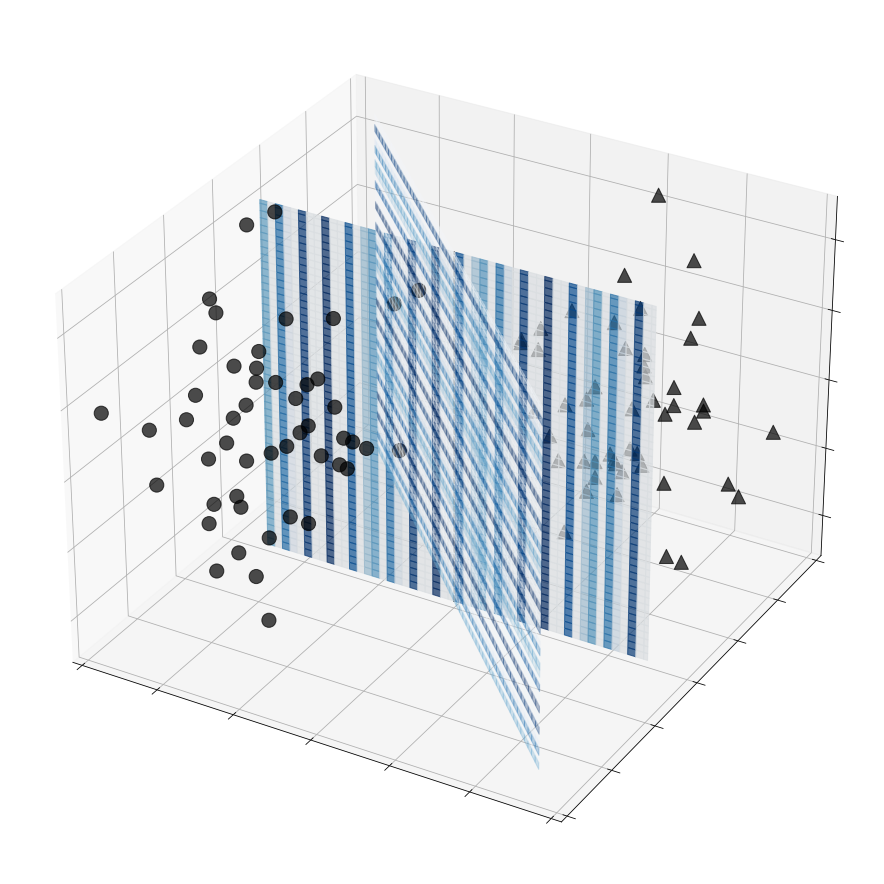

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import matplotlib
matplotlib.rcParams.update({'font.size': 30})

# Define the points to plot
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)

x = np.linspace(-5, 5, 100)
y = np.linspace(5, -5, 100)
X_p, Y_p = np.meshgrid(x, y)

# # Load the texture image
# img=cv2.imread('./frost/texture_strip.png')
# resized_img = cv2.resize(img, (100,100))
# texture_1 = np.array(resized_img)
# img=cv2.imread('./frost/texture_dot.png')
# resized_img = cv2.resize(img, (100,100))
# texture_2 = np.array(resized_img)
texture_1 = np.sin(X*20)
# texture_2 = np.sin(X*20) * np.sin(Y*20)
texture_2 = np.sin(X_p*20)

# Create the 3D figure
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111, projection='3d')

# Plot the planes
ax.plot([0, 0], [0, 0],zs=[-5, 5], alpha=1, color='black')
surf_0 = ax.plot_surface(Y_p, Y, X, facecolors=plt.cm.Blues(texture_1), # rainbow, viridis
                         alpha=0.3, label='Foreground Subspace')
surf_1 = ax.plot_surface(X, np.zeros((100, 100)), Y, facecolors=plt.cm.Blues(texture_2),
                         alpha=0.7, label='Background Subspace') # rstride=100, cstride=100, color='peru', 
surf_0._facecolors2d, surf_0._edgecolors2d = surf_0._facecolor3d, surf_0._edgecolor3d
surf_1._facecolors2d, surf_1._edgecolors2d = surf_1._facecolor3d, surf_1._edgecolor3d


# Generate data for two clusters
np.random.seed(0)  # for reproducibility
num_samples = 50
mean1 = [-3, -3, 0]
cov1 = np.eye(3) * np.array([2,2,5])
cluster1 = np.random.multivariate_normal(mean1, cov1, num_samples)
mean2 = [3, 3, 0]
cov2 = np.eye(3) * np.array([2,2,5])
cluster2 = np.random.multivariate_normal(mean2, cov2, num_samples)
# Add clusters to the plot
ax.scatter(cluster1[:, 0], cluster1[:, 1], cluster1[:, 2], 
           alpha=0.7, c='black', marker="o", s=200)
ax.scatter(cluster2[:, 0], cluster2[:, 1], cluster2[:, 2], 
           alpha=0.7, c='black', marker="^", s=200)

# Set labels
# ax.legend(bbox_to_anchor=[0.3, 1], prop={"weight":"bold"})
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])
ax.set_zlim([-5, 5])
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])
# ax.view_init(elev=20, azim=-35)
# plt.savefig(f"./fig/fig1.pdf", transparent=True, format="pdf", dpi=500, bbox_inches = "tight")
plt.show()